ADF Test for Differenced Data:
ADF Statistic: -7.898460594712363
p-value: 4.24798652948492e-12
The series is Stationary


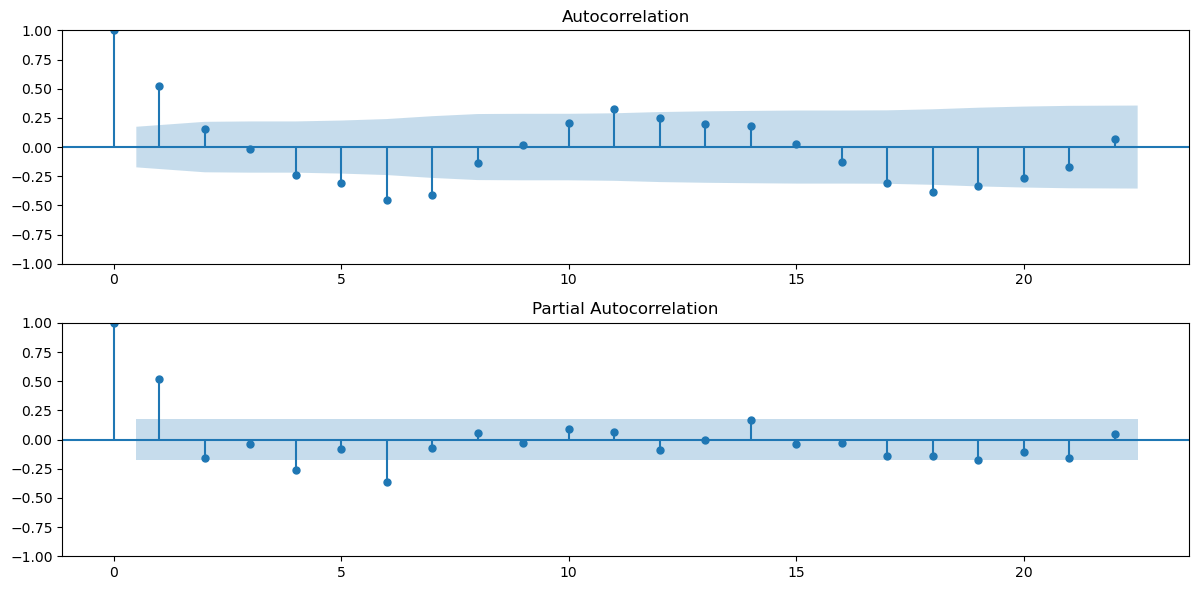

Best ARIMA parameters: (2, 1, 1)
2024-09-01    52.486953
2024-10-01    52.834871
2024-11-01    52.685397
2024-12-01    53.347490
2025-01-01    52.628810
                ...    
2034-08-01          NaN
2034-09-01          NaN
2034-10-01          NaN
2034-11-01          NaN
2034-12-01          NaN
Freq: MS, Name: predicted_mean, Length: 124, dtype: float64


In [1]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Load your dataset
df=pd.read_csv("c:/Users/satya/OneDrive/Desktop/PANDAS/Gur.csv")


# Step 2: Convert 'Month' column to datetime and set it as the index
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')  # Handle invalid parsing with 'coerce' to NaT
df.dropna(subset=['Month'], inplace=True)  # Drop rows where 'Month' is NaT
df.set_index('Month', inplace=True)

# Step 3: Perform differencing to make the data stationary
df['Price Difference'] = df['Price'].diff().dropna()

# Step 4: Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("The series is Non-Stationary")
    else:
        print("The series is Stationary")

# Test the differenced data
print("ADF Test for Differenced Data:")
adf_test(df['Price Difference'])

# Step 5: Plot the ACF and PACF to choose p and q parameters
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['Price Difference'].dropna(), ax=plt.gca())
plt.subplot(212)
plot_pacf(df['Price Difference'].dropna(), ax=plt.gca())
plt.tight_layout()
plt.show()

# Step 6: Perform a grid search to find the best ARIMA(p, d, q) model
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
for param in pdq:
    try:
        temp_model = ARIMA(df['Price'], order=param)
        temp_model_fit = temp_model.fit()
        if temp_model_fit.aic < best_aic:
            best_aic = temp_model_fit.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA parameters: {best_pdq}')

# Step 7: Fit the best ARIMA model
best_model = ARIMA(df['Price'], order=best_pdq)
best_model_fit = best_model.fit()

# Step 8: Forecast the next 5 years (60 months)
forecast_steps = 120  # 12 months * 5 years
forecast = best_model_fit.forecast(steps=forecast_steps)

# Step 9: Create a date range for the forecasted values
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:]

# # Step 10: Plot the original data and the forecasted values
# plt.figure(figsize=(10,6))
# plt.plot(df['Price'], label='Actual Prices', color='blue')
# plt.plot(future_dates, forecast, label='Forecasted Prices', color='orange', linestyle='--')
# plt.title('Price Forecast for the Next 5 Years')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Step 11: Check the residuals to see if they are white noise
# residuals = pd.DataFrame(best_model_fit.resid)
# plt.figure(figsize=(10,6))
# plt.plot(residuals, label='Residuals', color='red')
# plt.title('Residuals of the Model')
# plt.grid(True)
# plt.show()

# Step 12: Optional - Try a SARIMA model if seasonality is suspected
seasonal_model = SARIMAX(df['Price'], order=best_pdq, seasonal_order=(1, 2, 1, 12))
seasonal_model_fit = seasonal_model.fit()

# Step 13: Forecast with the SARIMA model (optional step)
# forecast_sarima = seasonal_model_fit.forecast(steps=120)
# plt.figure(figsize=(10,6))
# plt.plot(df['Price'], label='Actual Prices', color='blue')
# plt.plot(future_dates, forecast_sarima, label='SARIMA Forecasted Prices', color='green', linestyle='--')
# plt.title('Price Forecast with SARIMA for the Next 5 Years')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df['Price'][:train_size], df['Price'][train_size:]

# Step 2: Fit the SARIMA model on the training set
seasonal_model = SARIMAX(train, order=best_pdq, seasonal_order=(1, 2, 1, 12))
seasonal_model_fit = seasonal_model.fit()


# Step 1: Define the forecast period
future_start_date = '2024-09-01'  # Start from September 2024
future_end_date = '2034-12-01'    # End at December 2034
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='MS')

# Step 2: Forecast for the future period (from September 2024 to December 2034)
future_forecast_steps = len(future_dates)  # Calculate the number of steps
future_forecast = seasonal_model_fit.forecast(steps=future_forecast_steps)

# Step 3: Create a Pandas Series for the future forecast
future_forecast_series = pd.Series(future_forecast, index=future_dates)

# Display the future forecast
print(future_forecast_series)


# # Step 3: Forecast over the test set
# forecast_sarima = seasonal_model_fit.forecast(steps=len(test))

# # Step 4: Calculate error metrics to check the model's accuracy
# mae = mean_absolute_error(test, forecast_sarima)  # Mean Absolute Error
# mse = mean_squared_error(test, forecast_sarima)   # Mean Squared Error
# rmse = np.sqrt(mse)                               # Root Mean Squared Error

# print(f'Mean Absolute Error (MAE): {mae}')
# print(f'Mean Squared Error (MSE): {mse}')
# print(f'Root Mean Squared Error (RMSE): {rmse}')

# # Step 5: Visualize the forecast vs actual prices
# plt.figure(figsize=(10,6))
# plt.plot(test.index, test, label='Actual Prices', color='blue')
# plt.plot(test.index, forecast_sarima, label='Forecasted Prices', color='green', linestyle='--')
# plt.title('SARIMA Forecast vs Actual Prices')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()







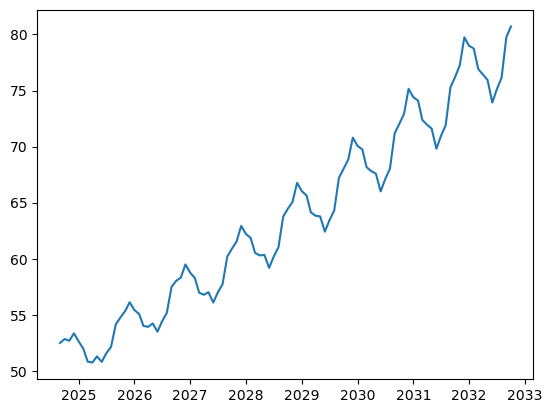

In [2]:
plt.plot(future_forecast_series)

In [3]:
future_forecast_series.isnull().sum()

26

In [4]:
print(seasonal_model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  102
Model:             SARIMAX(2, 1, 1)x(1, 2, 1, 12)   Log Likelihood                -117.868
Date:                            Wed, 30 Oct 2024   AIC                            247.736
Time:                                    19:27:03   BIC                            261.799
Sample:                                01-01-2014   HQIC                           253.361
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4271      0.262     -1.629      0.103      -0.941       0.087
ar.L2          0.0203      0.163   

In [5]:
print(train.isna().sum())


0


In [6]:
print(future_forecast)


2022-07-01    46.640360
2022-08-01    47.433392
2022-09-01    49.057894
2022-10-01    49.094952
2022-11-01    48.175016
                ...    
2032-06-01    73.930622
2032-07-01    75.119087
2032-08-01    76.157652
2032-09-01    79.751964
2032-10-01    80.712654
Freq: MS, Name: predicted_mean, Length: 124, dtype: float64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define the future start and end dates
future_start_date = '2024-09-01'  # Start from September 2024
future_end_date = '2036-12-01'     # End at December 2034
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='M')

# Step 2: Forecast for the future period (from September 2024 to December 2034)
future_forecast_steps = len(future_dates)  # Calculate the number of steps
future_forecast = seasonal_model_fit.forecast(steps=future_forecast_steps)

# Create a Pandas Series for the future forecast with the correct index
future_forecast_series = pd.Series(future_forecast, index=future_dates)



In [8]:
future_forecast

2022-07-01    46.640360
2022-08-01    47.433392
2022-09-01    49.057894
2022-10-01    49.094952
2022-11-01    48.175016
                ...    
2034-05-01    85.392793
2034-06-01    82.953302
2034-07-01    84.242196
2034-08-01    85.388491
2034-09-01    89.420993
Freq: MS, Name: predicted_mean, Length: 147, dtype: float64

In [9]:
start_date = '2024-08-01'
filtered_series = future_forecast[future_forecast.index >= start_date]


In [10]:
filtered_series.tail(64)

2029-06-01    62.412961
2029-07-01    63.435680
2029-08-01    64.293741
2029-09-01    67.216498
2029-10-01    68.010445
                ...    
2034-05-01    85.392793
2034-06-01    82.953302
2034-07-01    84.242196
2034-08-01    85.388491
2034-09-01    89.420993
Freq: MS, Name: predicted_mean, Length: 64, dtype: float64

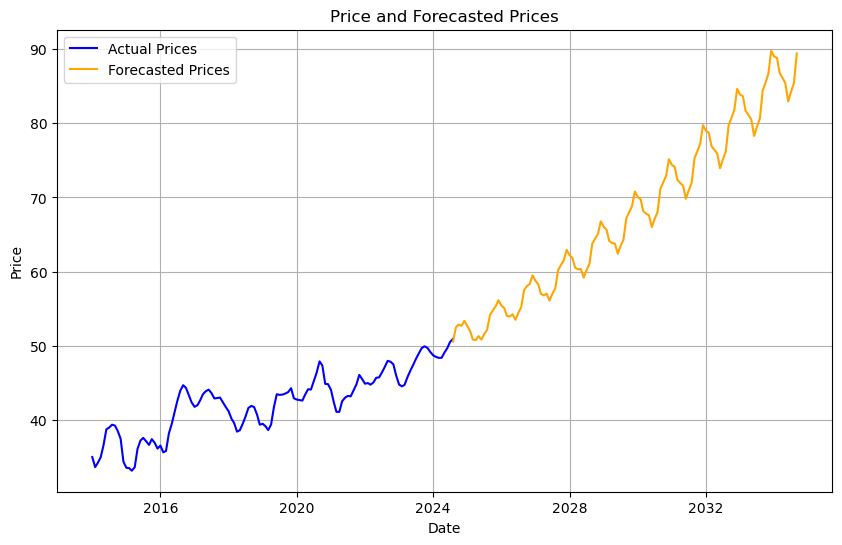

In [11]:
# Step 1: Create a new figure
plt.figure(figsize=(10, 6))

# Step 2: Plot the original Price data
plt.plot(df.index, df['Price'], label='Actual Prices', color='blue')

# Step 3: Plot the forecasted values
# Ensure that future_forecast_series has the correct index
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='M')
plt.plot(filtered_series, label='Forecasted Prices', color='orange')

# Step 4: Add titles and labels
plt.title('Price and Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Step 5: Show the plot
plt.show()


ADF Test for Differenced Data:
ADF Statistic: -7.898460594712363
p-value: 4.24798652948492e-12
The series is Stationary


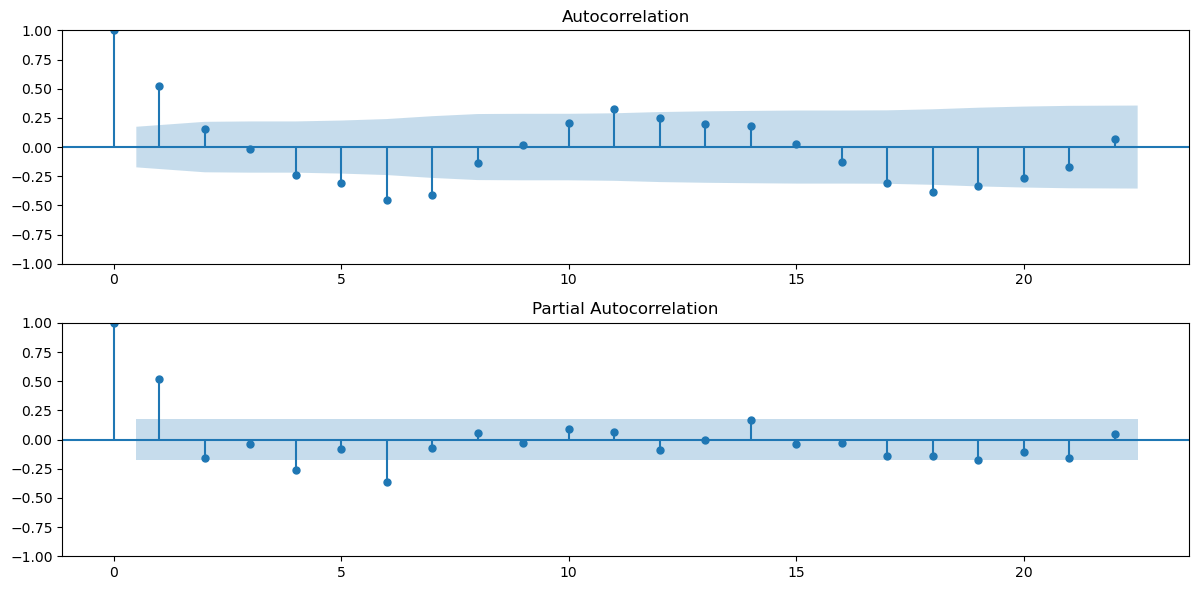

Best ARIMA parameters: (2, 1, 1)


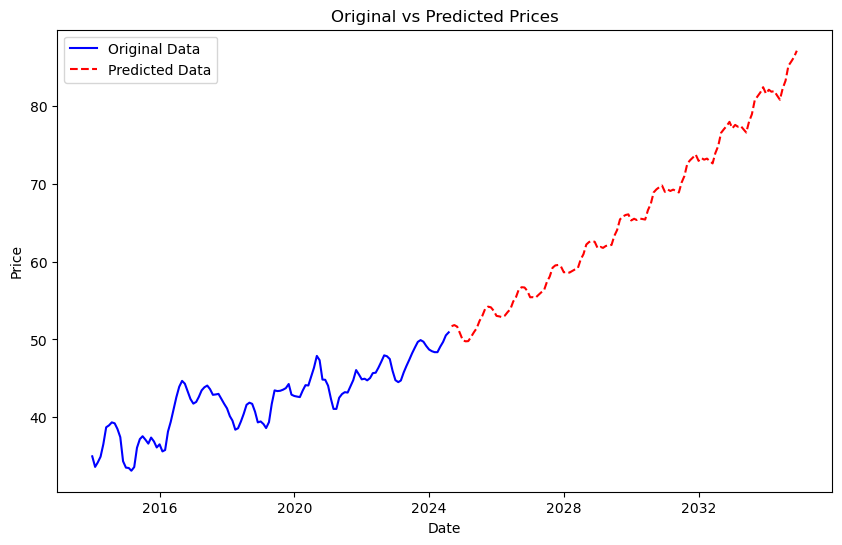

2014-01-01    34.980000
2014-02-01    33.620000
2014-03-01    34.180000
2014-04-01    34.930000
2014-05-01    36.530000
                ...    
2034-08-01    83.235987
2034-09-01    85.150352
2034-10-01    85.677323
2034-11-01    86.265596
2034-12-01    87.084145
Length: 252, dtype: float64


In [12]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Load your dataset
df = pd.read_csv("c:/Users/satya/OneDrive/Desktop/PANDAS/Gur.csv")

# Step 2: Convert 'Month' column to datetime and set it as the index
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')  # Handle invalid parsing with 'coerce' to NaT
df.dropna(subset=['Month'], inplace=True)  # Drop rows where 'Month' is NaT
df.set_index('Month', inplace=True)

# Step 3: Perform differencing to make the data stationary
df['Price Difference'] = df['Price'].diff().dropna()

# Step 4: Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("The series is Non-Stationary")
    else:
        print("The series is Stationary")

# Test the differenced data
print("ADF Test for Differenced Data:")
adf_test(df['Price Difference'])

# Step 5: Plot the ACF and PACF to choose p and q parameters
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['Price Difference'].dropna(), ax=plt.gca())
plt.subplot(212)
plot_pacf(df['Price Difference'].dropna(), ax=plt.gca())
plt.tight_layout()
plt.show()

# Step 6: Perform a grid search to find the best ARIMA(p, d, q) model
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
for param in pdq:
    try:
        temp_model = ARIMA(df['Price'], order=param)
        temp_model_fit = temp_model.fit()
        if temp_model_fit.aic < best_aic:
            best_aic = temp_model_fit.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA parameters: {best_pdq}')

# Step 7: Define the training set
train = df['Price']  # You can choose a portion of the data for training if needed

# Step 8: Fit the SARIMA model on the training set
seasonal_model = SARIMAX(train, order=best_pdq, seasonal_order=(1, 2, 1, 12))
seasonal_model_fit = seasonal_model.fit()

# Step 9: Define the forecast period
future_start_date = '2024-09-01'  # Start from September 2024
future_end_date = '2034-12-01'    # End at December 2034
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='MS')

# Step 10: Forecast for the future period (from September 2024 to December 2034)
future_forecast_steps = len(future_dates)  # Calculate the number of steps
future_forecast = seasonal_model_fit.forecast(steps=future_forecast_steps)

# Step 11: Create a Pandas Series for the future forecast
future_forecast_series = pd.Series(future_forecast, index=future_dates)

# Step 12: Plot original vs. predicted

plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(df.index, df['Price'], label='Original Data', color='blue')

# Plot the forecasted data
plt.plot(future_forecast_series.index, future_forecast_series, label='Predicted Data', color='red', linestyle='dashed')

# Add labels and title
plt.title('Original vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()
# Step 12: Combine original and predicted values into a single Pandas Series

# Create a copy of the original 'Price' series (to avoid modifying the original DataFrame)
combined_series = df['Price'].copy()

# Concatenate the original series with the predicted values
combined_series = pd.concat([combined_series, future_forecast_series])

# Display the combined series
print(combined_series)


In [13]:
# Import necessary libraries for accuracy calculation
import numpy as np

# Step 13: Calculate Accuracy using MAPE

# Split data into training and test sets
# Assuming you want to compare forecast with actual data, use the end portion of the actual data as 'test'
train_size = int(len(df) * 0.8)  # Use 80% of the data for training
train_data, test_data = df['Price'][:train_size], df['Price'][train_size:]

# Fit the SARIMA model again on the training data
seasonal_model = SARIMAX(train_data, order=best_pdq, seasonal_order=(1, 2, 1, 12))
seasonal_model_fit = seasonal_model.fit()

# Forecast the test period (use the length of the test set)
forecast_steps = len(test_data)
predicted_test = seasonal_model_fit.forecast(steps=forecast_steps)

# Step 14: Calculate MAPE (Mean Absolute Percentage Error)
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Calculate MAPE for the test period
mape = calculate_mape(test_data, predicted_test)

# Calculate accuracy as (100 - MAPE)
accuracy = 100 - mape

# Print the accuracy
print(f'Model Accuracy: {accuracy:.2f}%')



Model Accuracy: 98.10%


In [14]:
import pickle  # Import pickle for saving the combined series

# Combine original and predicted values into a single Pandas Series
combined_series = df['Price'].copy()
combined_series = pd.concat([combined_series, future_forecast_series])

# Save the combined series as a .pkl file
with open("combined_series.pkl", "wb") as f:
    pickle.dump(combined_series, f)

print("Combined series saved to 'combined_series.pkl' for use in Streamlit app.")


Combined series saved to 'combined_series.pkl' for use in Streamlit app.
